In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import openpyxl

In [2]:
train=pd.read_csv('../data/train.csv')
test=pd.read_csv('../data/test.csv')
# combine test dataset and train dataset
df =pd.concat([train, test], axis=0)

In [3]:
# remove unknown
df_no_unknown = df[(df['job'] != 'unknown') & (df['education'] != 'unknown') & (df['marital'] != 'unknown') & (df['default'] != 'unknown') & (df['housing'] != 'unknown') & (df['loan'] != 'unknown')]

In [5]:
# filter subscribed
df_prev_success = df_no_unknown[df_no_unknown['subscribe'] == 'yes']

In [7]:
features_transform = ['job', 'education', 'marital', 'default', 'housing', 'loan',
                      'contact','month','day_of_week']

In [18]:
one_hot_df = df_prev_success[['id', 'age', 'duration', 'campaign', 'pdays', 'previous']].reset_index()
for feature in features_transform:
    encoder = OneHotEncoder(sparse_output=False)
    feature_df = pd.DataFrame(encoder.fit_transform(df_prev_success[[feature]]),
                              columns=encoder.get_feature_names_out([feature]))
    one_hot_df = pd.concat([one_hot_df, feature_df], axis=1)

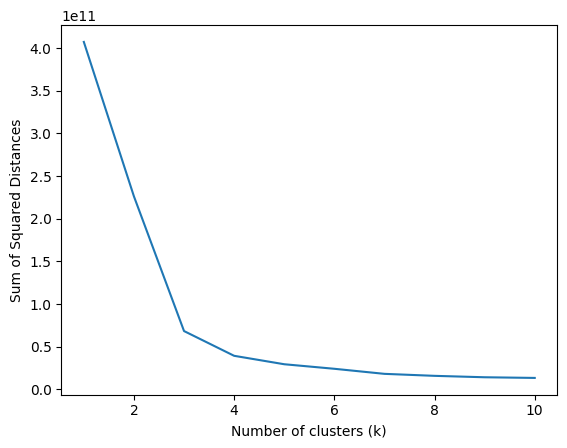

In [19]:
inertia = []
for nc in range(1,11):
    kmeans = KMeans(n_clusters=nc, random_state=0).fit(one_hot_df)
    inertia.append(kmeans.inertia_)
interias = pd.DataFrame({'n_clusters': range(1, 11), 'inertia': inertia})

plot = interias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plot.legend().set_visible(False)
plt.show()

In [20]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(one_hot_df)
memb = pd.DataFrame(kmeans.labels_, one_hot_df.index, columns=['Cluster'])
utilities_memb = pd.concat([one_hot_df, memb], axis=1)
utilities_memb

,index,id,age,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,Cluster
0,4,5,45,3178,1,240,4,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,10,11,37,2746,1,703,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,34,35,66,216,3,5,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,45,46,31,2814,3,160,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,59,60,56,1705,9,528,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,7462,29963,37,2011,3,741,6,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
3375,7466,29967,54,653,1,760,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
3376,7474,29975,54,595,4,487,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
3377,7488,29989,38,1642,1,59,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
